# Part I: Research Question

## A. Purpose of Data Analysis
### A1. Research Question

Can the sentiment of reviews be predicted using a neural network?

### A2. Goals of the Data Analysis

The goal of this data analysis is to develop a model capable of determining the positive or negative sentiment of Yelp reviews in order to better understand customer needs.

### A3. Neural Network

RNN, or recurrent neural networks, are often used to perform text classification tasks, as RNN captures the sequential information present in the input data (Pai, 2020). RNN can utilize the dependency between words in predictions, which enables the model to capture the negative sentiment from negations like "not" when they sequentially precede words like "good." 


# Part II: Data Preparation
## B. Data Cleaning Process
### B1. Exploratory Data Analysis
Exploratory data analysis and data preprocessing were performed on the chosen data set in the cells below. Data set was checked for NAs, null values, and duplicates. Duplicates were identified and dropped. Further results of this analysis include the following:

- Presence of Unusual Characters
    - The data set was checked for non-English and non-ASCII characters
    - é occurred 3 times and ê occurred once in borrowed words (like 'fiancé' and 'crêpe')
- Vocabulary Size: 1645 words
    - Top 10 Frequent Words:
        - not, 216 times
        - food, 126 times
        - place, 110 times
        - good, 106 times
        - service, 87 times
        - go, 78 times
        - great, 71 times
        - back, 60 times
        - time, 55 times
        - like, 50 times
    - Longest Review: 32 words
        - 'a drive thru means you do not want to wait around for half an hour for your food, but somehow when we end up going here they make us wait and wait.'
    - Shortest Review: 1 word
        - 'DELICIOUS!!'
    - Mean Review Length: 10.9 words
    - Median Review Length: 10 words
- Proposed Word Embedding Length
    - Using the rule from Lakshmanan, the embedding dimension can be found by taking 1.6 times the square root of the vocabulary size of 1645 (Lakshmanan et al., 2021). From the calculation provided below, the proposed word embedding length is 65.
- Statistical Justification for Chosen Maximum Sequence Length
    - The 95th percentile of the preprocessed training data was calculated below and found to be 12, so the maximum padded sequence length was chosen to be 12, in order to capture 95% of the lengths of preprocessed sequences in the training data.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import re
from collections import Counter
import tensorflow as tf
import random
SEED = 36
os.environ['PYTHONHASHSEED'] = str(SEED) # Random seeds across libraries
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED) 
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Force TensorFlow to use deterministic operations for reproducibility 
from tensorflow import keras 
from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer # Convert input text to tokens
from tensorflow.keras.callbacks import EarlyStopping # Stop training at a threshold
from tensorflow.keras.models import load_model # To Load a saved model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences # For padding

import nltk
import string
import contractions
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import unicodedata
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/drewmendez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/drewmendez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/drewmendez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/drewmendez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/drewmendez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
# Import data into dataframe

df = pd.read_csv("/Users/drewmendez/Documents/WGU/D213/T2/sentimentdata/yelp_labelled.txt", sep='\t', header=None, names=['Review', 'Sentiment'])

print(df.shape)
print(df['Sentiment'].unique()) 

df.head()

(1000, 2)
[1 0]


,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
# Check for NAs, Nulls, and Duplicates

print('NAs:\n', df.isna().sum())
print('Nulls:\n', df.isnull().sum())
print('Duplicates:\n', df.duplicated().sum())

NAs:
 Review       0
Sentiment    0
dtype: int64
Nulls:
 Review       0
Sentiment    0
dtype: int64
Duplicates:
 4


In [4]:
# Drop Duplicates

df = df.drop_duplicates().reset_index(drop=True)
print(df.shape)

(996, 2)


In [5]:
# Add Column for Word Count

def number_of_words(text):
    words = text.split()
    word_count = len(words)
    return word_count

df['Word_Count'] = df['Review'].apply(number_of_words)

# df.to_csv('output_check1.csv')
df.head()


,Review,Sentiment,Word_Count
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


In [6]:
# Detect unusual characters

def detect_unusual_chars(texts):
    # Find non-ASCII characters and emojis
    unusual_chars = Counter()
    
    for text in texts:
        # Detect all characters that are not ASCII 
        # (^\x00-\x7F means negation of hexadecimal range of ASCII characters)
        non_ascii = re.findall(r'[^\x00-\x7F]', text)
        
        # Detect emojis (range of unicode for emojis)
        emojis = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF]', text)
        unusual_chars.update(non_ascii + emojis)

    print(f"Unusual characters: {unusual_chars}")
    
    return unusual_chars



unusual_chars = detect_unusual_chars(df['Review'])
pattern = '|'.join(re.escape(char) for char in unusual_chars.keys())
filtered_df = df[df['Review'].str.contains(pattern, regex=True, na=False)]


print("\nRows with unusual chars:")
print(filtered_df)


Unusual characters: Counter({'é': 3, 'ê': 1})

Rows with unusual chars:
                                                Review  Sentiment  Word_Count
150  My fiancé and I came in the middle of the day ...          1          19
598  I really enjoyed Crema Café before they expand...          1          17
821         The crêpe was delicate and thin and moist.          1           8
911  The only thing I wasn't too crazy about was th...          0          17


In [7]:
# Verify that negations are in stopwords to exclude them

print("not" in stopwords.words('english'))
print("no" in stopwords.words('english'))
print("nor" in stopwords.words('english'))

True
True
True


In [8]:
# Adapted from SQLPey

def get_wordnet_pos(treebank_tag):
    # Convert POS tags to WordNet format
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



def preprocess_sentiment(text):
    # Expand contractions
    text = contractions.fix(text)
    
    # Convert non-English characters (é to e, ê to e)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
    
    # Remove everything that is not a word character or whitespace character
    text = re.sub(r"[^\w\s]", " ", text)
    
    # Lowercase
    text = text.lower()
    
    # Tokenize and part of speech tag
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    
    # Lemmatize with POS
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words 
        and len(word) > 1
        and not word.startswith("'")
    ]
    
    return tokens

In [9]:
# New Column of Preprocessed Data 

df['Review_tokens'] = df['Review'].apply(preprocess_sentiment).tolist()
df['token_length'] = df['Review_tokens'].apply(len)

print(df.iloc[150])
print(df.iloc[821])

df.head()


Review           My fiancé and I came in the middle of the day ...
Sentiment                                                        1
Word_Count                                                      19
Review_tokens    [fiance, come, middle, day, greet, seat, right...
token_length                                                     8
Name: 150, dtype: object
Review           The crêpe was delicate and thin and moist.
Sentiment                                                 1
Word_Count                                                8
Review_tokens                [crepe, delicate, thin, moist]
token_length                                              4
Name: 821, dtype: object


,Review,Sentiment,Word_Count,Review_tokens,token_length
0,Wow... Loved this place.,1,4,"[wow, love, place]",3
1,Crust is not good.,0,4,"[crust, not, good]",3
2,Not tasty and the texture was just nasty.,0,8,"[not, tasty, texture, nasty]",4
3,Stopped by during the late May bank holiday of...,1,15,"[stop, late, may, bank, holiday, rick, steve, ...",9
4,The selection on the menu was great and so wer...,1,12,"[selection, menu, great, price]",4


In [10]:
# Length of Vocabulary

all_tokens = []
for sublist in df['Review_tokens']:  # Loop through each review
    for token in sublist:          # Loop through each token in the review
        all_tokens.append(token)   # Add token to list

vocab = Counter(all_tokens)
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"Top 10 frequent words: {vocab.most_common(10)}")

Vocabulary size: 1645
Top 10 frequent words: [('not', 216), ('food', 126), ('place', 110), ('good', 106), ('service', 87), ('go', 78), ('great', 71), ('back', 60), ('time', 55), ('like', 50)]


In [11]:
# Using the 4th root rule for Embedding Dimension

embedding_dim = int(round(1.6 * (vocab_size ** 0.5)))

print(f"Embedding Dimension: {embedding_dim}")

Embedding Dimension: 65


In [12]:
# Determine minimum, median, and maximum lengths of reviews

def review_lengths(df, review_col, word_count_col):
    lengths = df[word_count_col].values
    
    # Compute maximum and minimum word lengths and their indices
    max_words, min_words = np.max(lengths), np.min(lengths)
    max_index, min_index = np.argmax(lengths), np.argmin(lengths)
    
    print(f"Mean review length: {np.mean(lengths).round(1)}")
    print(f"Median review length: {np.median(lengths)}")
    print(f"Longest review length: {max_words}") 
    print(f"Review: '{df[review_col].iloc[max_index]}'")
    print(f"Shortest review length: {min_words}")
    print(f"Review: '{df[review_col].iloc[min_index]}'")
    

In [13]:
# Determine minimum, median, and maximum lengths of reviews

review_lengths(df, 'Review', 'Word_Count')

Mean review length: 10.9
Median review length: 10.0
Longest review length: 32
Review: 'a drive thru means you do not want to wait around for half an hour for your food, but somehow when we end up going here they make us wait and wait.'
Shortest review length: 1
Review: 'DELICIOUS!!'


### B2. Goals of Tokenization Process

There are two goals of the tokenization process: the linguistic tokenization of text to tokens which is shown in the cells above, and the vectorization of tokens to numbers which is shown in the cells below. Together, these comprise the overarching goal of encoding sentences as numerical sequences for use with neural networks. All relevant packages are listed at the beginning of the notebook. 

The linguistic tokenization of text to tokens was done alongside the data preprocessing using the function `preprocess_sentiment()`, defined above. This function performed preprocessing like expanding contractions using `contractions.fix()`, converting non-English characters (é to e, ê to e) using `unicodedata.normalize()`, removing everything but word or whitespace characters using regex's `re.sub()`, and making all words lowercase using `lower()`. 

Additionally, the function performed word tokenization that split the sentences into lists of words, or tokens, using `word_tokenize()`. Then by using `WordNetLemmatizer()`, the tokens were lemmatized using their parts of speech, reducing the tokens to their root word ('loved' to 'love'). Finally, all stop words ('is', 'the', 'and', etc) were removed, with the exception of 'no', 'not', and 'nor' in order to retain negative sentiment. The code and output of this function is provided in the cells above.

The second stage is the vectorization of the tokens, which converts the tokens to numerical sequences. This is done separately on each of the training and testing sets to avoid data leakage, so the data must first be split into training, testing, and validation sets using `train_test_split()`, with the industry standard of 70%, 15%, and 15% respectively. The Keras `Tokenizer()` is fit on the training set, then both training and testing sets are converted to sequences using the tokenizer. 

After the padding process described below, this effectively encodes the tokens as numerical sequences for use with neural networks. The code for this is given below.



In [14]:
df.head()

,Review,Sentiment,Word_Count,Review_tokens,token_length
0,Wow... Loved this place.,1,4,"[wow, love, place]",3
1,Crust is not good.,0,4,"[crust, not, good]",3
2,Not tasty and the texture was just nasty.,0,8,"[not, tasty, texture, nasty]",4
3,Stopped by during the late May bank holiday of...,1,15,"[stop, late, may, bank, holiday, rick, steve, ...",9
4,The selection on the menu was great and so wer...,1,12,"[selection, menu, great, price]",4


In [15]:
# Splitting data into Training and Testing sets

X = df['Review_tokens']
y = df['Sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify = y)

# 70% training data and 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=SEED, 
    stratify = y)

# split 30% temporary into 15% test data and 15% validation data
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=SEED, 
    stratify = y_temp)


In [42]:
print(len(X_train)/len(X))
print(len(X_test)/len(X))
print(len(X_val)/len(X))

0.6997991967871486
0.1495983935742972
0.15060240963855423


In [17]:
# Convert processed training and testing set tokens to sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Build the vocabulary based on training data
tokenizer.fit_on_texts(X_train)

# Convert training set into integer sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Convert testing set into integer sequences
test_sequences = tokenizer.texts_to_sequences(X_test)

# Convert validation set into integer sequences
val_sequences = tokenizer.texts_to_sequences(X_val)

### B3. Padding Process

The padding process to standardize the length of the numerical sequences ensures that all inputs of the neural network have the same length. Since models such as RNNs or LSTMs expect inputs with uniform size, sequences must be padded with zeros to fix all sequences to a specified length. The 95th percentile of the processed training data is calculated below and was found to be 12, so the maximum padded sequence length was chosen to be 12 to capture 95% of the lengths of the sequences. The sequences were padded after the text sequences, as RNNs process data from left to right. The first sequence of the training data set is given below as an example of a padded sequence.

First padded sequence of training data set: [43,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]

In [18]:
# 95th Percentile of Preprocessed Reviews

max_length = int(np.percentile(df['token_length'], 95))
print(f"Padding length (95th percentile): {max_length}")

Padding length (95th percentile): 12


In [19]:
# Padding Sequences

train_padded = pad_sequences(
    train_sequences, 
    maxlen=max_length, 
    padding='post', 
    truncating='post')

test_padded = pad_sequences(
    test_sequences, 
    maxlen=max_length, 
    padding='post', 
    truncating='post')

val_padded = pad_sequences(
    val_sequences, 
    maxlen=max_length, 
    padding='post', 
    truncating='post')

train_padded[0]

array([43,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

### B4. Categories of Sentiment

As shown below, there are two categories of sentiment for this model, `0` and `1`, which represent negative sentiment and positive sentiment respectively. The activation function commonly used for binary classification in neural networks is the sigmoid function, which maps the model's raw outputs to the range [0, 1], the result of which can be interpreted as the probability of the positive sentiment. The sigmoid function, $\sigma$, is given below:
$$ \sigma (z) = \frac{1}{1 + e^{-z}} $$

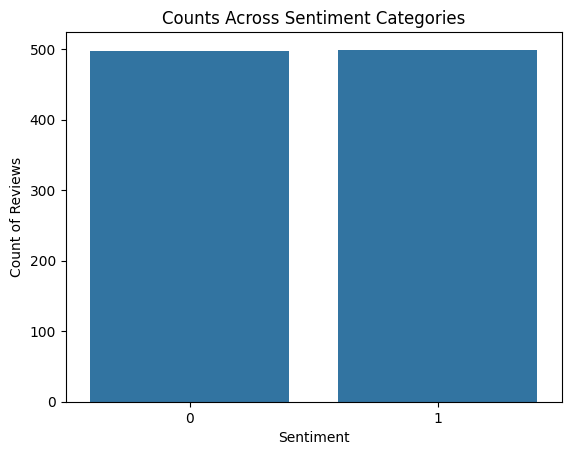

In [20]:
# Plotting distribution of sentiments in the dataset

sns.countplot(x='Sentiment', data=df)
plt.title('Counts Across Sentiment Categories')
plt.ylabel('Count of Reviews');

### B5. Steps to Prepare Data for Analysis

The code used to prepare the data for analysis is provided throughout the cells above. The steps used to prepare the data are given below.

1. Data was checked for nulls, missing values, and duplicates. Duplicates were removed.
2. Column was added with the word count for each review.
3. Non-ASCII, emojis, and other unusual characters were detected.
4. Data was preprocessed using a function defined above. Preprocessing included:
    - Expanding contractions
    - Converting non-English characters
    - Removing everything but word or whitespace characters
    - Lowercase all text
    - Converting reviews into lists of words, or tokens
    - Lemmatizing, or reducing words to their roots
    - Removing all stop words except negations
5. Data was split into training, testing, and validation sets, with 70%, 15%, and 15% respectively.
6. Initialize tokenizer on training data only, to avoid data leakage.
7. Training, testing, and validation data converted from tokens to integer sequences.
8. 95th Percentile of training data sequence lengths was calculated to determine maximum padded sequence length.
9. Integer sequences of training, testing, and validation data were padded with zeros at the end of the sequence to the maximum length.

### B6. Prepared Data Set

The following .CSVs are provided in a compressed folder:

- `df`: processed data frame
- `X_train`: training features, or text reviews, used to train the model
- `X_test`: test features for final evaluation
- `X_val`: validation features to tune hyperparameters
- `train_padded`: `X_train` padded to the chosen maximum sequence length
- `test_padded`: `X_test` padded to the chosen maximum sequence length
- `val_padded`: `X_val` padded to the chosen maximum sequence length
- `y_train`: training labels, or sentiment, for training data
- `y_test`: labels for test data
- `y_val`: labels for validation data


In [41]:
df.to_csv('D213_T2_processed_dataframe.csv')

X_train.to_csv('D213_T2_X_train.csv')
X_test.to_csv('D213_T2_X_test.csv')
X_val.to_csv('D213_T2_X_val.csv')

pd.DataFrame(train_padded).to_csv('D213_T2_X_train_padded.csv', index=False)
pd.DataFrame(test_padded).to_csv('D213_T2_X_test_padded.csv', index=False)
pd.DataFrame(val_padded).to_csv('D213_T2_X_val_padded.csv', index=False)

y_train.to_csv('D213_T2_y_train.csv')
y_test.to_csv('D213_T2_y_test.csv')
y_val.to_csv('D213_T2_y_val.csv')

# Part III: Network Architecture
## C. Description of Network
### C1. Model Summary
The code below shows the ablation testing of four models with four combinations of values for hyperparameters for `dropout` and `recurrent_dropout` in the LSTM layer. The combinations are:

- `dropout_0.2` with `dropout` = 0.2 and `recurrent_dropout` = 0
- `dropout_0.3` with `dropout` = 0.3 and `recurrent_dropout` = 0
- `dropout_0.2_recurrent_0.2` with `dropout` = 0.2 and `recurrent_dropout` = 0.2
- `dropout_0.3_recurrent_0.2` with `dropout` = 0.3 and `recurrent_dropout` = 0.2

The best model was selection by finding the model with the highest accuracy. The summary for the best model is provided below.


In [44]:
print(vocab_size)
print(embedding_dim)
print(max_length)

1645
65
12


In [43]:
lstm_units = 64      # Number of LSTM units


# Define the model
def model_creation(dropout_rate, recurrent_rate): 
    model = Sequential([
        # Layer 1: Embedding (converts integer tokens to dense vectors)
        Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim, 
            input_length=max_length),
        
        # Layer 2: LSTM (processes sequential data)
        LSTM(lstm_units, 
             dropout=dropout_rate, 
             recurrent_dropout=recurrent_rate
            ),
        
        # Layer 3: Dense (output layer for binary classification)
        Dense(1, activation='sigmoid') 
    ])
 
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [24]:
results = {}

# Hyperparameter combinations
configs = [
    {'name': 'dropout_0.2', 'dropout_rate': 0.2, 'recurrent_rate': 0},
    {'name': 'dropout_0.3', 'dropout_rate': 0.3, 'recurrent_rate': 0},
    {'name': 'dropout_0.2_recurrent_0.2', 'dropout_rate': 0.2, 'recurrent_rate': 0.2},
    {'name': 'dropout_0.3_recurrent_0.2', 'dropout_rate': 0.3, 'recurrent_rate': 0.2}
]

# Loop through each config
for config in configs:
    print(f"Training {config['name']}...")
    
    model = model_creation(
        dropout_rate=config['dropout_rate'],
        recurrent_rate=config['recurrent_rate']
    )
    
    history = model.fit(
        train_padded, y_train,
        epochs=10,
        validation_data=(val_padded, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    
    test_loss, test_acc = model.evaluate(test_padded, y_test, verbose=0)
    
    # Save results
    results[config['name']] = {
        'model': model,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'history': history.history
    }

# Print final comparison
print("\nComparison of models:")
for k, v in results.items():
    print(f"{k}: Test Loss = {v['test_loss']:.4f}, Test Accuracy = {v['test_accuracy']:.4f}")


Training dropout_0.2...


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-27 15:09:55.474934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-27 15:09:55.474955: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-27 15:09:55.474960: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-27 15:09:55.474979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-27 15:09:55.474994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04

Training dropout_0.3...
Training dropout_0.2_recurrent_0.2...
Training dropout_0.3_recurrent_0.2...

Comparison of models:
dropout_0.2: Test Loss = 0.4983, Test Accuracy = 0.7987
dropout_0.3: Test Loss = 0.4225, Test Accuracy = 0.8322
dropout_0.2_recurrent_0.2: Test Loss = 0.3846, Test Accuracy = 0.8523
dropout_0.3_recurrent_0.2: Test Loss = 0.4320, Test Accuracy = 0.8456


In [26]:
best_model = None
best_accuracy = -float('inf')
best_loss = float('inf')
best_model_name = None

for name, metrics in results.items():
    acc = metrics['test_accuracy']
    loss = metrics['test_loss']
    
    # Check if model has better accuracy
    if acc > best_accuracy:
        best_accuracy = acc
        best_loss = loss
        best_model = metrics['model']  # Get the actual model object
        best_model_name = name
        
    # If accuracy is the same, check for lower loss
    elif acc == best_accuracy and loss < best_loss:
        best_loss = loss
        best_model = metrics['model']
        best_model_name = name

# Print best model
print(f"\nBest model is '{best_model_name}' with:")
print(f"Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"Test Loss: {results[best_model_name]['test_loss']:.4f}")


Best model is 'dropout_0.2_recurrent_0.2' with:
Test Accuracy: 0.8523
Test Loss: 0.3846


In [27]:
print(f"Actual epochs run: {len(results[best_model_name]['history']['loss'])}")

# # Generate and print the summary

best_model.summary()

Actual epochs run: 7


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 12, 65)         │       106,925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,812 (1.61 MB)

 Trainable params: 140,270 (547.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 280,542 (1.07 MB)

In [37]:
# Last training accuracy
final_train_accuracy = history.history['accuracy'][-1]  

# Last validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]  

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Final Training Accuracy: 0.9842
Final Validation Accuracy: 0.7733


### C2. Layers and Parameters

The first layer is the embedding layer, which converts the integer-encoded words from `Tokenizer` into vector representations that capture semantic relationships. The embedding layer's input dimension is the vocabulary size, the output dimension is the embedding dimension, and the input length is the maximum padded sequence length. The embedding layer accounts for the majority of the parameter count with 106,925 parameters or about 76% of the trainable parameters.

The second layer, the LSTM layer, processes sequential word embeddings to capture contextual dependencies, like "not good" versus "very good". The LSTM layer has 33,280 parameters, or about 23% of the trainable parameters.

The third layer, the dense or output layer, maps the LSTM's final state to a sentiment probability using the sigmoid function, as discussed above. The dense layer has 65 parameters, which brings the total number of trainable parameters to 140,270. The sum of the trainable parameters and the 280,542 optimizer variables is 420,812 total parameters.


### C3. Choice of Hyperparameters

Since binary classification requires output in the range [0, 1], the sigmoid function, as discussed above, is the typical choice for such binary tasks. The choice of 65D for the embedding layer ensures each word has a meaningful vector, while the LSTM's 64 units captures sequential patterns while avoiding excessive patterns incurred at 128+ units (Abadi, M., et al. 2016). The one unit for the dense output layer matches the needs of binary classification.

The binary cross-entropy loss function is typically used in binary classification problems, as it quantifies the difference between actual class labels and the predicted probabilities of the model's output, which ensures optimal probability calibration (GeeksforGeeks, 2024). Training employs the Adam optimizer due to its efficiency and adaptive learning rate capabilities (GeeksforGeeks, 2022). The Early Stopping criteria is used to prevent overfitting, as it stops training when validation loss plateaus.

The chosen model evaluation metrics include accuracy for overall performance and F1 to address potential class imbalances.



# Part IV: Model Evaluation
## D. Evaluation of the Model Training Process
### D1. Stopping Criteria

The model employed early stopping on validation loss with patience = 3, dynamically determining the number of epochs to be 7 actual training epochs, which reduced training time by being more computationally efficient. Since the model was not trained for too long, this approach may also have prevented overfitting (Machine Learning Glossary, 2024). The output of the final training epoch is given above.

### D2. Model Fitness

As discussed in Section C1, both dropout and recurrent dropout were utilized during training to further regularize the LSTM model, encouraging it to learn robust, generalizable patterns rather than memorizing specific sequences. The model that best fit the data with the highest accuracy was the model with `dropout` = 0.2 and `recurrent` = 0.2.

Early stopping (patience = 3) was implemented to prevent overfitting by halting training at epoch 7 and restoring model weights from epoch 4, where validation loss reached its minimum (validation loss = 0.6071, training loss = 0.2075).

The effectiveness of early stopping is evidenced by the Loss vs Epochs graph below: while training loss continued decreasing beyond epoch 4, validation loss began to rise, a pattern characteristic of overfitting. Low training loss paired with rising validation loss indicates that the model was starting to memorize the training data rather than generalize to unseen data. This overfitting trend, beginning after the best epoch (epoch 4), is clearly visible in the graphs.


### D3. Visualization of Training Process

Provided below is the graph of Loss vs Epochs, which shows training loss, validation loss, and the best epoch, and the graph of Accuracy vs Epochs, which shows training accuracy, validation accuracy, and the best epoch. The graph of Loss vs Epochs shows that the best epoch is epoch 4 where validation loss is the lowest. Training and validation losses diverged after epoch 4, with training loss continuing to decrease while validation loss began increasing. This behavior, along with stagnating validation accuracy, suggests that the model began to overfit after epoch 4. Early stopping based on minimum validation loss successfully prevented further overfitting and selected the best model.


Best Epoch: 4
Training Loss at Best Epoch: 0.2075
Validation Loss at Best Epoch: 0.6071


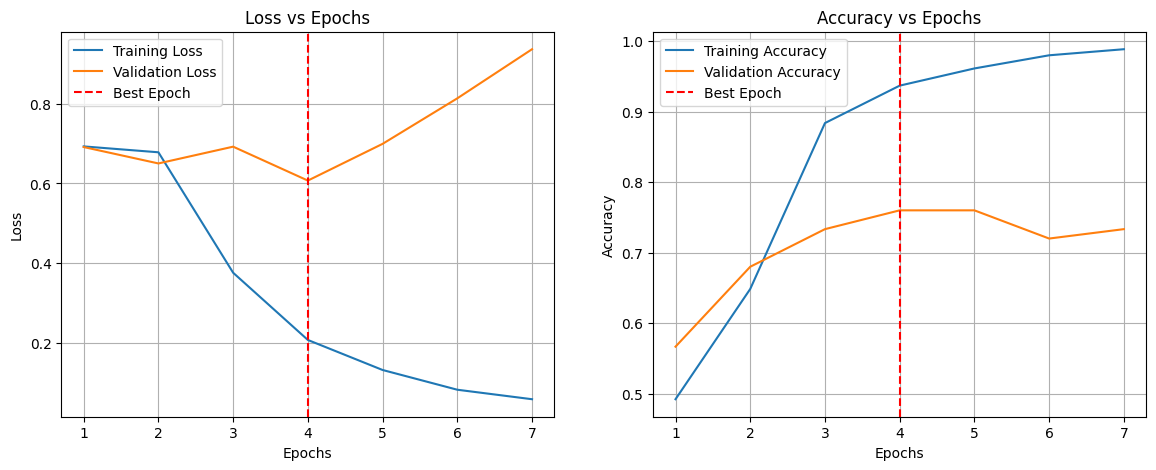

In [36]:
# Plot training/validation loss
best_history = results[best_model_name]['history']

# Find epoch where validation loss was lowest
best_epoch = np.argmin(best_history['val_loss'])
epochs_range = np.arange(1, len(best_history['loss']) + 1)

# Extract losses at the best epoch
best_train_loss = best_history['loss'][best_epoch]
best_val_loss = best_history['val_loss'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}")  # Start epoch numbering from 1
print(f"Training Loss at Best Epoch: {best_train_loss:.4f}")
print(f"Validation Loss at Best Epoch: {best_val_loss:.4f}")


plt.figure(figsize=(14, 5))

# Plot Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_history['loss'], label='Training Loss')
plt.plot(epochs_range, best_history['val_loss'], label='Validation Loss')
plt.axvline(best_epoch + 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, best_history['val_accuracy'], label='Validation Accuracy')
plt.axvline(best_epoch + 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()



### D4. Predictive Accuracy

As shown below, the model achieved a test accuracy of 85.23% and a test F1 score of 84.51%, indicating strong predictive performance. The close alignment between accuracy and F1 score suggests that the model maintains a good balance between precision and recall, and is not biased toward a particular class. These results demonstrate that the model generalizes well to unseen data and makes consistently reliable predictions.

In [35]:
# Predict on test set
y_pred = (best_model.predict(test_padded) > 0.5).astype(int)

# Calculate metrics
# accuracy = accuracy_score(y_test, y_pred)
loss, accuracy = best_model.evaluate(test_padded, y_test) 
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8757 - loss: 0.3531
Test Accuracy: 0.8523
Test F1 Score: 0.8451


# Part V: Summary and Recommendations
## E. Code Used to Save the Trained Network
The code  used to save the trained neural network is shown below.


In [39]:
model.save('best_model.keras')

## F. Functionality of the Neural Network

The architecture of the model was kept lightweight to encourage generalization and reduce the risk of overfitting. The Embedding layer allowed the network to learn useful dense representations of words, capturing semantic similarity beyond raw token indices. The single LSTM layer, with capacity of 64 units, enabled the model to learn sequential dependencies in the text, which is essential for understanding context in natural language tasks. To mitigate overfitting, regular dropout was applied to the input connections, and recurrent dropout was applied to the hidden state transitions within the LSTM. The final Dense layer with a sigmoid activation function appropriately mapped the learned features to a probability score for binary classification. Overall, the architectural choices directly contributed to the model's strong test performance as discussed in D4.


## G. Recommended Course of Action
Based on the model’s strong predictive performance, the recommended course of action is to deploy the sentiment classifier to analyze customer reviews, enabling the identification of trends in customer satisfaction and support for data-driven business improvements. Ongoing monitoring and periodic retraining are advised to ensure the model continues to perform accurately as new data becomes available.

# Part VI: Reporting
## H. Interactive Development Environment
All work for this performance assessment was completed in a TensorFlow virtual environment in JupyterLab, as can be seen in the attached D213_PA_MendezD_T2_A1.ipynb, which was then exported to PDF.

## I. Acknowledgement of Web Sources

How to Use WordNet Lemmatization and POS Tagging in Python for Accurate Results. (2024, November 23). Sqlpey. https://sqlpey.com/python/wordnet-lemmatization-and-pos-tagging-in-python/

Team, K. (n.d.). Keras documentation: Keras layers API. Keras.io. https://keras.io/api/layers/


## J. Acknowledgement of Sources

Abadi, M., et al. (2016). TensorFlow: Large-Scale Machine Learning on Heterogeneous Distributed Systems. ArXiv.org. https://arxiv.org/abs/1603.04467

GeeksforGeeks. (2024, May 27). Binary Cross EntropyLog Loss for Binary Classification. GeeksforGeeks. https://www.geeksforgeeks.org/binary-cross-entropy-log-loss-for-binary-classification/

GeeksforGeeks. (2022, December 4). Adam Optimizer in Tensorflow. GeeksforGeeks. https://www.geeksforgeeks.org/adam-optimizer-in-tensorflow/

Lakshmanan, V., Robinson, S., & Munn, M. (2021). Machine Learning Design Patterns.

Machine Learning Glossary. (2024). Google for Developers. https://developers.google.com/machine-learning/glossary#early_stopping

TensorFlow Team. “Introducing TensorFlow Feature Columns.” GoogleBlog, Google, 20 Nov. 2017, developers.googleblog.com/en/introducing-tensorflow-feature-columns/.

Pai, Aravindpai. (2020, February 17). CNN vs. RNN vs. ANN - Analyzing 3 Types of Neural Networks. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/